# GenCC data plots without any external API calls 

In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from Bio import Entrez

In [2]:
# Imports
gencc_s = pd.read_csv("/home/azureuser/submissions-export-csv", header=0) # skiprows=15
out_dir = "/home/azureuser/gencc_summaries/"
gencc_s.shape


(21668, 30)

/tmp/ipykernel_1062087/2378375530.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=filtered_df, palette=present_color_dict, inner=None, order=classification_order)


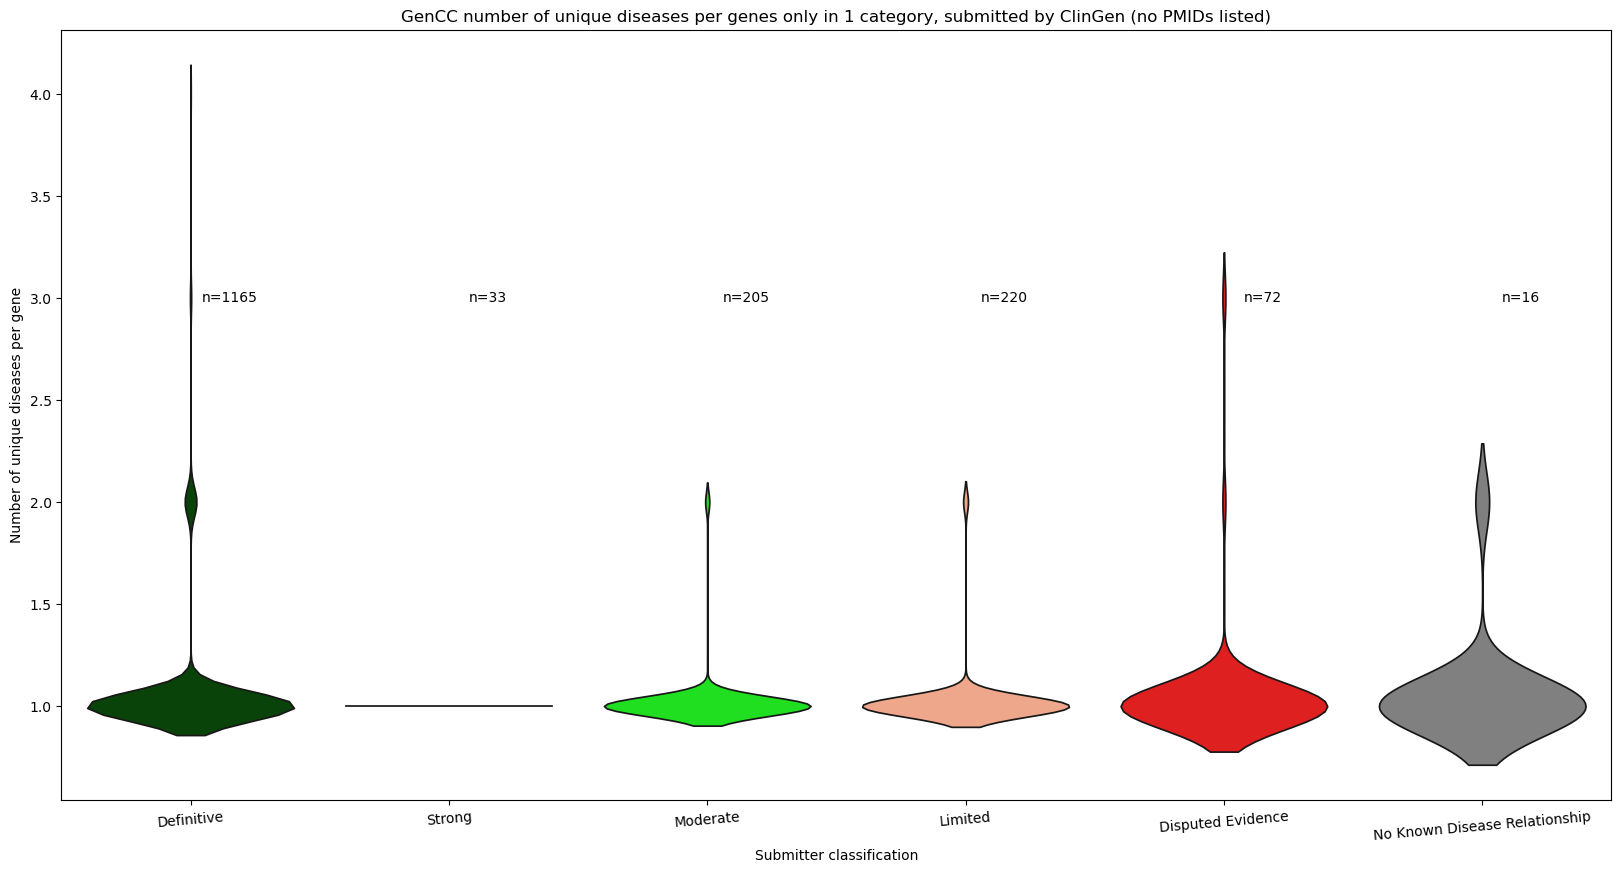

In [3]:
# GenCC number of unique diseases per genes only in 1 category, submitted by ClinGen (note no PMIDs listed)

# Filter to include only the rows where 'submitted_as_submitter_name' is 'ClinGen'
clingen_df = gencc_s[gencc_s['submitter_title'] == 'ClinGen']

# First, group by 'gene_symbol' and 'submitted_as_classification_name', and count unique 'disease_title'
grouped_df = clingen_df.groupby(['gene_symbol', 'submitted_as_classification_name'])['disease_title'].nunique().reset_index(name='unique_disease_count')

# Then, count the number of categories for each gene
category_counts = grouped_df['gene_symbol'].value_counts()

# Get the genes that appear in exactly one category
unique_genes = category_counts[category_counts == 1].index

# Filter the grouped_df to include only the unique genes
filtered_df = grouped_df[grouped_df['gene_symbol'].isin(unique_genes)]

# Define color scheme
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Get the classifications present in the filtered data
present_classifications = filtered_df['submitted_as_classification_name'].unique()

# Create a new color dict that only includes the present classifications
present_color_dict = {k: color_dict[k] for k in present_classifications if k in color_dict}

# Get the order of the classifications as they appear in color_dict
classification_order = [k for k in color_dict.keys() if k in present_classifications]

# Create the violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=filtered_df, palette=present_color_dict, inner=None, order=classification_order)

# Add the count of data points for each violin
counts = filtered_df['submitted_as_classification_name'].value_counts().loc[classification_order]
medians = filtered_df.groupby('submitted_as_classification_name')['unique_disease_count'].median().loc[classification_order]
for i, (count, median) in enumerate(zip(counts, medians)):
    plt.text(i+0.15, median + 2, f'n={count}', ha='center', va='center', color='black')

plt.xticks(rotation=5)
plt.xlabel('Submitter classification')
plt.ylabel('Number of unique diseases per gene')
plt.title("GenCC number of unique diseases per genes only in 1 category, submitted by ClinGen (no PMIDs listed)")

plt.show()

In [4]:
# Remove rows with no PMIDs in 'submitted_as_classification_name' columns and clean up the classification names in 'submitted_as_classification_name' column
# NOTE: in this case, ClinGen is removed because it has no PMIDs listed

# Replace submitted_as_pmids column blank values with NaN
gencc_s['submitted_as_pmids'] = gencc_s['submitted_as_pmids'].replace('', np.nan)
    
# Remove rows where 'submitted_as_pmids' is NaN
gencc_s = gencc_s.dropna(subset=['submitted_as_pmids'])

# Replace all occurrences of 'LIMITED' with 'Limited' and 'Definitive ' with 'Definitive'
gencc_s['submitted_as_classification_name'] = gencc_s['submitted_as_classification_name'].replace({'LIMITED': 'Limited', 'Definitive ': 'Definitive', 'Modeare': 'Moderate', ' Moderate': 'Moderate', 'Moderate ': 'Moderate', 'Disputed evidence': 'Disputed Evidence', 'Disputed': 'Disputed Evidence', 'STRONG': 'Strong', 'Strong ': 'Strong', ' Strong': 'Strong'})

gencc_s.shape


(13907, 30)

In [ ]:
# Clean up the 'submitted_as_pmids' column

# Split the 'submitted_as_pmids' column on ','
gencc_s['submitted_as_pmids'] = gencc_s['submitted_as_pmids'].str.split(',')

# Use explode to have each number appear on a separate row
gencc_s = gencc_s.explode('submitted_as_pmids').reset_index(drop=True)

# Remove rows with NaN or empty values in the "submitted_as_pmids" column
gencc_s = gencc_s.dropna(subset=['submitted_as_pmids'])
gencc_s['submitted_as_pmids'] = gencc_s['submitted_as_pmids'].str.replace(' ', '')

print(gencc_s.shape)

gencc_s.head()


(41557, 30)


,uuid,gene_curie,gene_symbol,disease_curie,disease_title,disease_original_curie,disease_original_title,classification_curie,classification_title,moi_curie,...,submitted_as_submitter_name,submitted_as_classification_id,submitted_as_classification_name,submitted_as_date,submitted_as_public_report_url,submitted_as_notes,submitted_as_pmids,submitted_as_assertion_criteria_url,submitted_as_submission_id,submitted_run_date
0,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,Genomics England PanelApp,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,24939586,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08
1,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,Genomics England PanelApp,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,25862627,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08
2,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,Genomics England PanelApp,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,27942422,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08
3,GENCC_000104-HGNC_1097-OMIM_613707-HP_0000006-...,HGNC:1097,BRAF,MONDO:0013380,LEOPARD syndrome 3,OMIM:613707,LEOPARD syndrome 3,GENCC:100002,Strong,HP:0000006,...,Genomics England PanelApp,GENCC:100002,Strong,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,19206169,NaN,000104.pa48.v1.73.hgnc1097.m1.p1,2020-10-08
4,GENCC_000104-HGNC_1097-OMIM_613707-HP_0000006-...,HGNC:1097,BRAF,MONDO:0013380,LEOPARD syndrome 3,OMIM:613707,LEOPARD syndrome 3,GENCC:100002,Strong,HP:0000006,...,Genomics England PanelApp,GENCC:100002,Strong,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,21396583,NaN,000104.pa48.v1.73.hgnc1097.m1.p1,2020-10-08


Mann-Whitney U test between Limited and Supportive: U=1262164.0, p=1.826858263069133e-50
Mann-Whitney U test between Limited and Strong: U=1620214.5, p=1.4321727042282053e-18
Mann-Whitney U test between Limited and No Known Disease Relationship: U=74160.0, p=0.007794790987614445
Mann-Whitney U test between Limited and Definitive: U=146805.5, p=0.04174999039402178
Mann-Whitney U test between Limited and Moderate: U=105204.5, p=0.006664491277684817
Mann-Whitney U test between Limited and Disputed Evidence: U=5868.5, p=0.39198547610605916
Mann-Whitney U test between Supportive and Strong: U=6675424.5, p=4.989885556398355e-34
Mann-Whitney U test between Supportive and No Known Disease Relationship: U=292800.0, p=8.317463613264101e-13
Mann-Whitney U test between Supportive and Definitive: U=590249.0, p=1.3186275069553233e-12
Mann-Whitney U test between Supportive and Moderate: U=416550.0, p=6.18400441690906e-17
Mann-Whitney U test between Supportive and Disputed Evidence: U=23149.5, p=0.037

/tmp/ipykernel_373855/227002174.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=grouped_df, palette=color_dict, order=color_dict.keys(), inner=None)


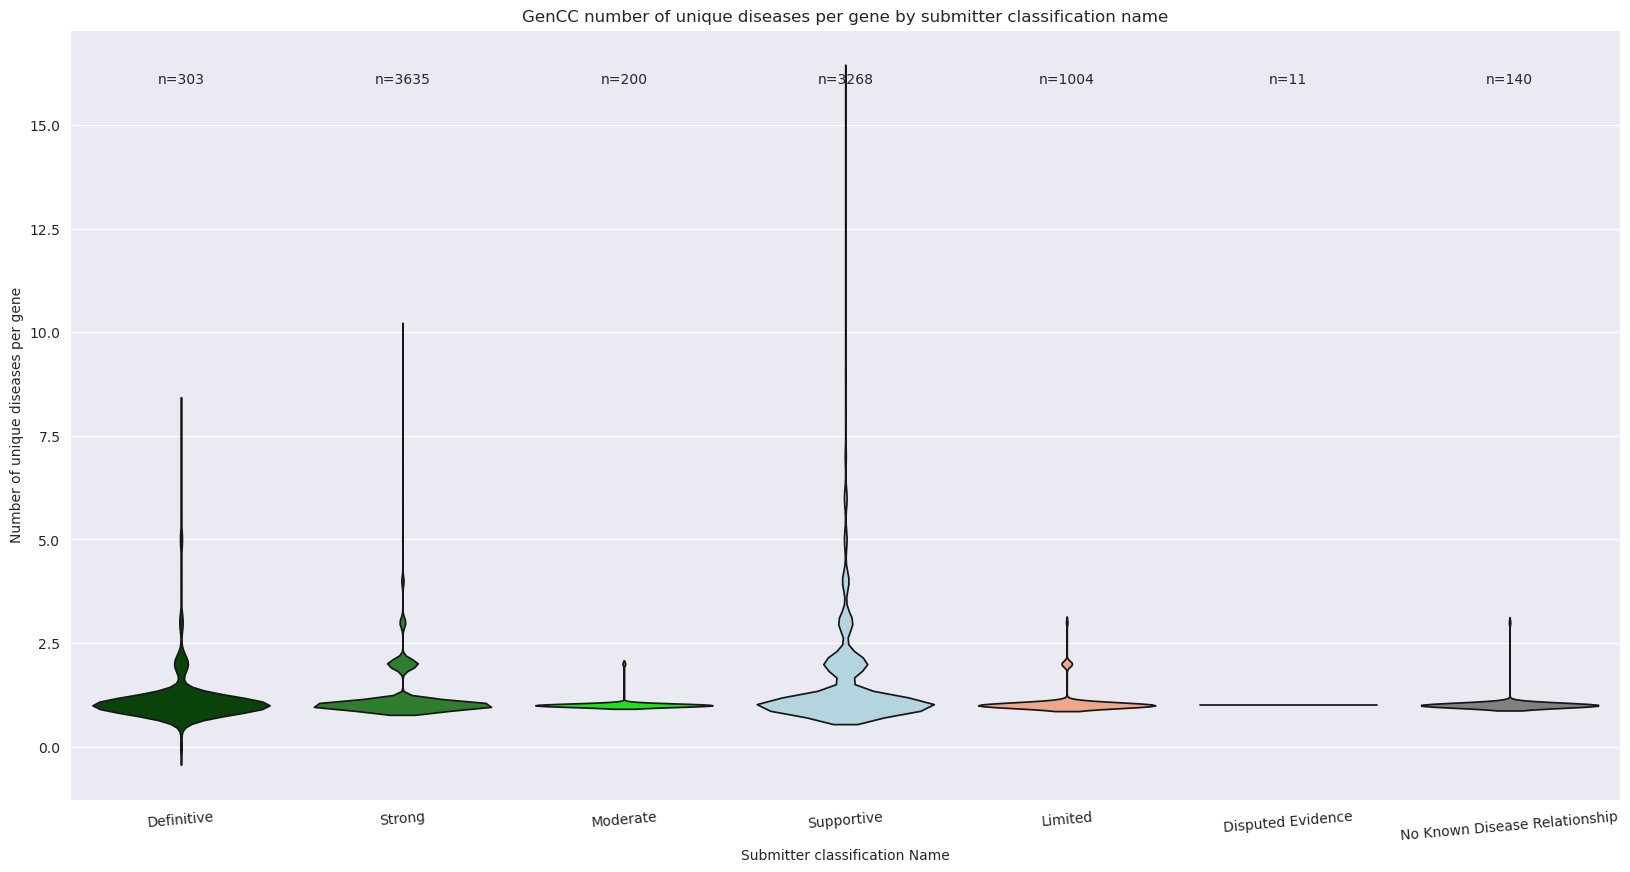

In [ ]:
# GenCC number of unique diseases per gene by submitter classification name and significance metric (Mann-Whitney U test)

sns.set_style("darkgrid")

# Define color scheme
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Group by 'gene_symbol' and 'submitted_as_classification_name', and count unique 'disease_title'
grouped_df = gencc_s.groupby(['gene_symbol', 'submitted_as_classification_name'])['disease_title'].nunique().reset_index(name='unique_disease_count')

# Convert 'submitted_as_classification_name' to Categorical and specify the order of the categories
grouped_df['submitted_as_classification_name'] = pd.Categorical(grouped_df['submitted_as_classification_name'], categories=color_dict.keys(), ordered=True)

# Calculate Mann-Whitney U test for each pair of distributions
classifications = list(grouped_df['submitted_as_classification_name'].unique())
significant_pairs = []
for i in range(len(classifications)):
    for j in range(i+1, len(classifications)):
        data1 = grouped_df[grouped_df['submitted_as_classification_name'] == classifications[i]]['unique_disease_count']
        data2 = grouped_df[grouped_df['submitted_as_classification_name'] == classifications[j]]['unique_disease_count']
        stat, p = mannwhitneyu(data1, data2)
        print(f'Mann-Whitney U test between {classifications[i]} and {classifications[j]}: U={stat}, p={p}')
        if p < 0.05:
            significant_pairs.append((classifications[i], classifications[j]))

# Create violin plot
plt.figure(figsize=(15, 15)) # 20, 10 without significant pairs
sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=grouped_df, palette=color_dict, order=color_dict.keys(), inner=None)

# Add count of data points for each violin
counts = grouped_df['submitted_as_classification_name'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, grouped_df['unique_disease_count'].max(), f'n={count}', ha='center')  # adjust y-coordinate as needed

plt.xticks(rotation=5)
plt.xlabel('Submitter classification Name')
plt.ylabel('Number of unique diseases per gene')
plt.title("GenCC number of unique diseases per gene by submitter classification name")

# Add lines for significant pairs
y_max = grouped_df['unique_disease_count'].max() + 10  # adjust y-coordinate as needed
for i, pair in enumerate(significant_pairs):
    x1 = classifications.index(pair[0])
    x2 = classifications.index(pair[1])
    y = y_max + i*5  # adjust these values as needed
    plt.plot([x1, x2], [y, y], color='black')
    plt.text((x1+x2)*0.5, y, '*', ha='center')
    
plt.show()

In [67]:
# GenCC number of unique diseases per genes only in 1 category, by submitter classification name

# First, group by 'gene_symbol' and 'submitted_as_classification_name', and count unique 'disease_title'
grouped_df = gencc_s.groupby(['gene_symbol', 'submitted_as_classification_name'])['disease_title'].nunique().reset_index(name='unique_disease_count')

# Then, count the number of categories for each gene
category_counts = grouped_df['gene_symbol'].value_counts()

# Get the genes that appear in exactly one category
unique_genes = category_counts[category_counts == 1].index

# Filter the grouped_df to include only the unique genes
filtered_df = grouped_df[grouped_df['gene_symbol'].isin(unique_genes)]

# Define color scheme
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Create the violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=filtered_df, palette=color_dict, inner=None, order=color_dict.keys())


# Add the count of data points for each violin
counts = filtered_df['submitted_as_classification_name'].value_counts().loc[color_dict.keys()]
medians = filtered_df.groupby('submitted_as_classification_name')['unique_disease_count'].median().loc[color_dict.keys()]
for i, (count, median) in enumerate(zip(counts, medians)):
    plt.text(i+0.15, median + 4, f'n={count}', ha='center', va='center', color='black')

plt.xticks(rotation=5)
plt.xlabel('Submitter classification Name')
plt.ylabel('Number of unique diseases per gene')
plt.title("GenCC number of unique diseases per genes only in 1 category, by submitter classification name")

plt.show()

['Limited', 'Supportive', 'Strong', 'Supportive', 'No Known Disease Relationship', ..., 'Supportive', 'Limited', 'Strong', 'Supportive', 'Strong']
Length: 8561
Categories (7, object): ['Definitive' < 'Strong' < 'Moderate' < 'Supportive' < 'Limited' < 'Disputed Evidence' < 'No Known Disease Relationship']

In [ ]:
# GenCC number of unique diseases per genes only in 1 category, by submitter classification name PanelApp Australia 

# Filter to include only the rows where 'submitted_as_submitter_name' is 'ClinGen'
panelapp_df = gencc_s[gencc_s['submitter_title'] == 'PanelApp Australia']

# First, group by 'gene_symbol' and 'submitted_as_classification_name', and count unique 'disease_title'
grouped_df = panelapp_df.groupby(['gene_symbol', 'submitted_as_classification_name'])['disease_title'].nunique().reset_index(name='unique_disease_count')

# Then, count the number of categories for each gene
category_counts = grouped_df['gene_symbol'].value_counts()

# Get the genes that appear in exactly one category
unique_genes = category_counts[category_counts == 1].index

# Filter the grouped_df to include only the unique genes
filtered_df = grouped_df[grouped_df['gene_symbol'].isin(unique_genes)]

# Define color scheme
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Get the classifications present in the filtered data
present_classifications = filtered_df['submitted_as_classification_name'].unique()

# Create a new color dict that only includes the present classifications
present_color_dict = {k: color_dict[k] for k in present_classifications if k in color_dict}

# Get the order of the classifications as they appear in color_dict
classification_order = [k for k in color_dict.keys() if k in present_classifications]

# Create the violin plot
plt.figure(figsize=(20, 10))
sns.violinplot(x='submitted_as_classification_name', y='unique_disease_count', data=filtered_df, palette=present_color_dict, inner=None, order=classification_order)

# Add the count of data points for each violin
counts = filtered_df['submitted_as_classification_name'].value_counts().loc[classification_order]
medians = filtered_df.groupby('submitted_as_classification_name')['unique_disease_count'].median().loc[classification_order]
for i, (count, median) in enumerate(zip(counts, medians)):
    plt.text(i+0.15, median + 2, f'n={count}', ha='center', va='center', color='black')

plt.xticks(rotation=5)
plt.xlabel('Submitter classification Name')
plt.ylabel('Number of unique diseases per gene')
plt.title("GenCC number of unique diseases per genes only in 1 category, by submitter classification name PanelApp Australia")

plt.show()

In [ ]:
# Gene category span (i.e. how many categories each gene is in)

# Count the number of categories for each gene
category_counts = grouped_df['gene_symbol'].value_counts()

# Count the frequency of each number of categories
frequency_counts = category_counts.value_counts()

# Plot the frequencies
plt.figure(figsize=(10, 6))
frequency_counts.sort_index().plot(kind='bar')
plt.xlabel('Number of Categories')
plt.ylabel('Frequency')
plt.title('Gene Category Span')
plt.show()

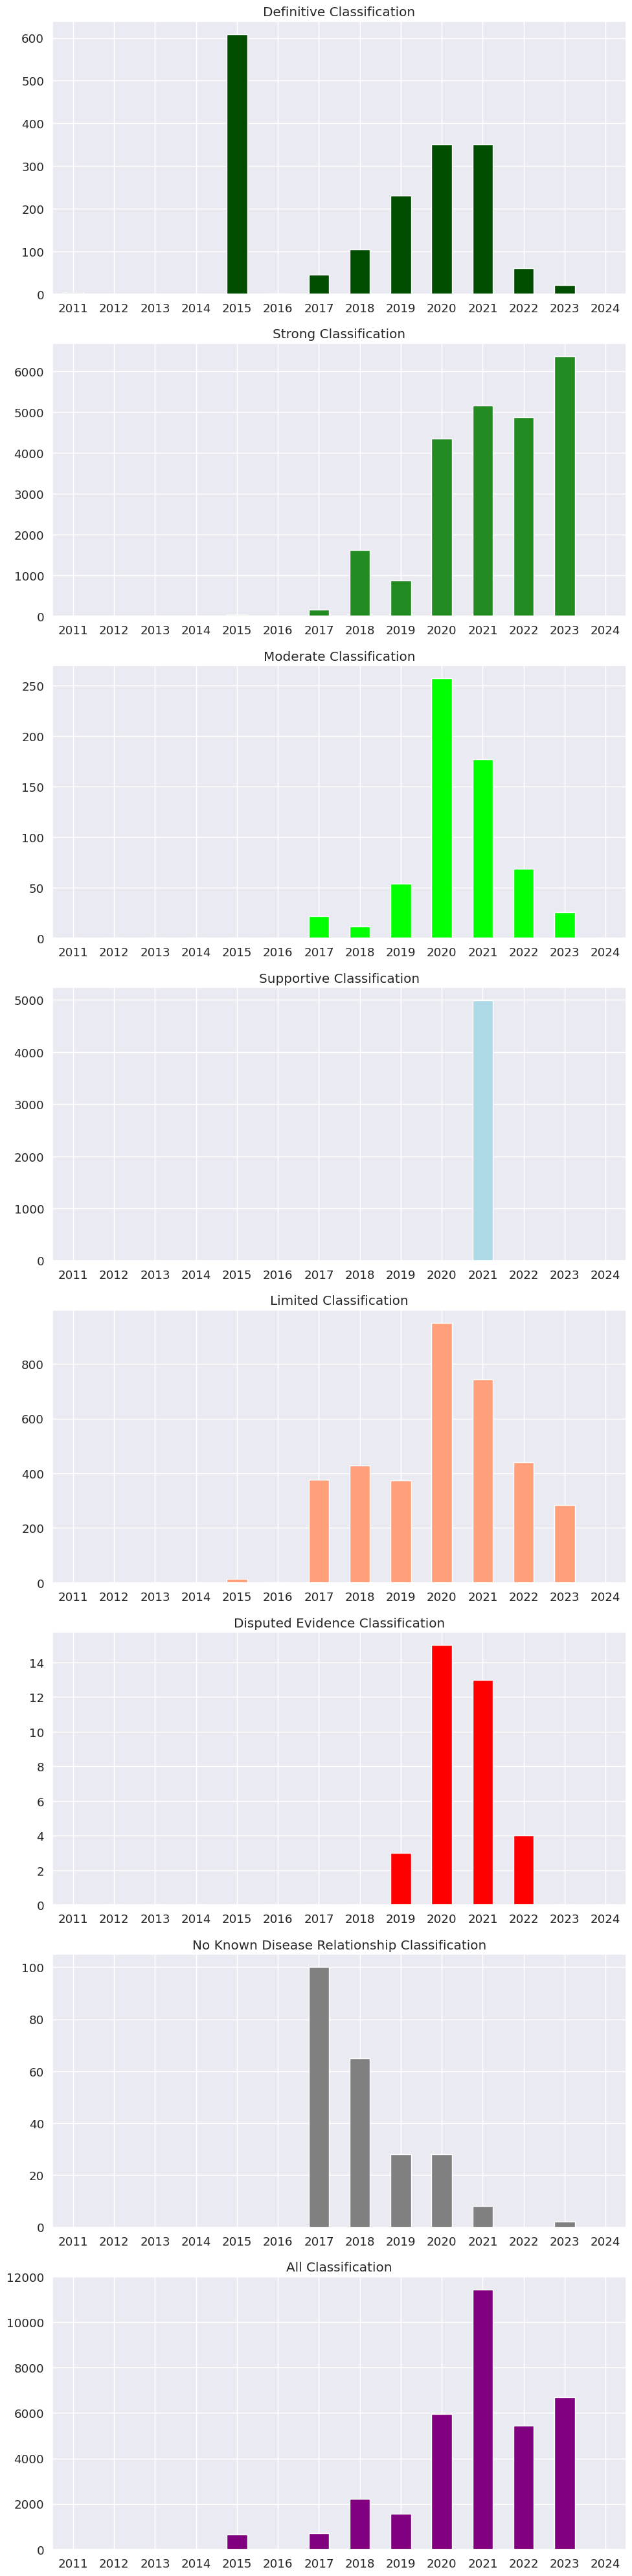

In [121]:
# GenCC frequency of classifications over time (i.e. years)

# Convert 'submitted_as_date' to datetime and extract the year
gencc_s['submitted_as_date'] = pd.to_datetime(gencc_s['submitted_as_date'])
gencc_s['submitted_year'] = gencc_s['submitted_as_date'].dt.year

# Create a range of years from 2011 to 2024
years = pd.RangeIndex(2011, 2025)

# Remove rows with 'NaN' in 'submitted_as_classification_name' column
gencc_s = gencc_s.dropna(subset=['submitted_as_classification_name'])

# Create a color dictionary
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Create a figure with a subplot for each classification in color_dict plus one for all classifications
fig, axs = plt.subplots(len(color_dict) + 1, 1, figsize=(10, 5*(len(color_dict)+1)))

# Plot a bar plot of the year for each classification in color_dict
for i, classification in enumerate(list(color_dict.keys()) + ['All']):
    if classification == 'All':
        classification_df = gencc_s
        color = 'purple'  # Choose a color for the 'All' category
    else:
        classification_df = gencc_s[gencc_s['submitted_as_classification_name'] == classification]
        color = color_dict.get(classification, 'grey')  # Use color from dictionary if it exists, else use 'grey'
    
    classification_df['submitted_year'].value_counts().reindex(years, fill_value=0).sort_index().plot.bar(ax=axs[i], color=color)
    axs[i].set_title(f'{classification} Classification')
    axs[i].set_xticklabels(years, rotation=0)  # Set x-axis tick rotation

plt.tight_layout()
plt.show()

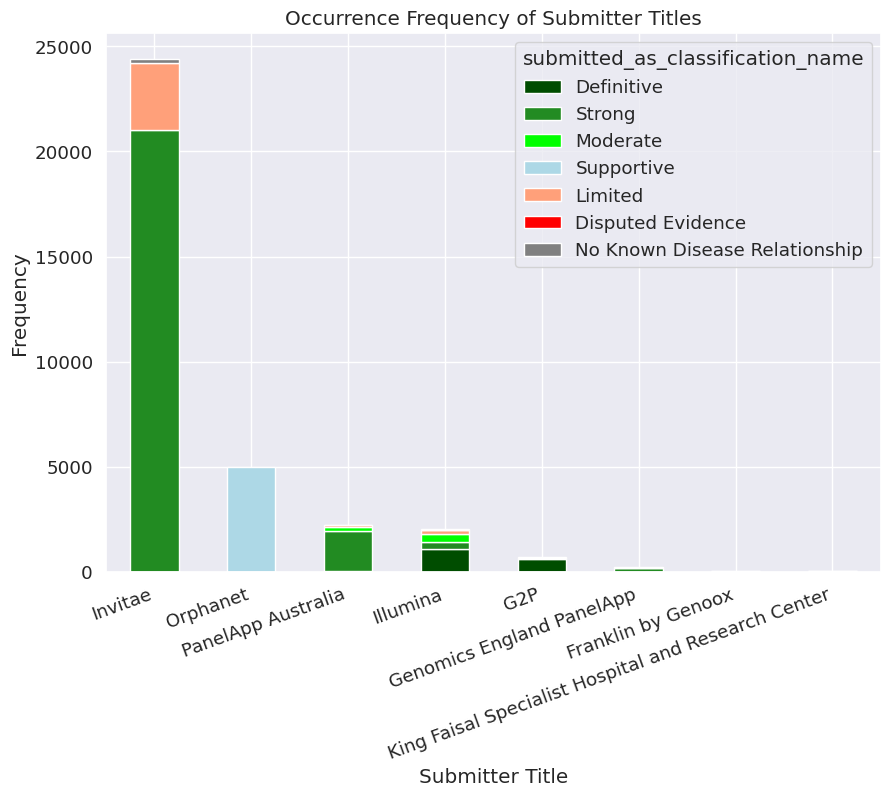

In [135]:
# Classification frequency by submitter title (all classifications)

# Create a color dictionary
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey'
}

# Group by 'submitter_title' and 'submitted_as_classification_name', count the size, unstack and fill NaN with 0
grouped_df = gencc_s.groupby(['submitter_title', 'submitted_as_classification_name']).size().unstack(fill_value=0)

# Sort the columns based on the order in color_dict
grouped_df = grouped_df[list(color_dict.keys())]

# Add a total column
grouped_df['Total'] = grouped_df.sum(axis=1)

# Sort by the total column in descending order
grouped_df = grouped_df.sort_values('Total', ascending=False)

# Remove the total column
grouped_df = grouped_df.drop(columns='Total')

# Plot a stacked bar plot with the colors from color_dict
grouped_df.plot(kind='bar', stacked=True, color=list(color_dict.values()), figsize=(10, 7))

plt.title('Occurrence Frequency of Submitter Titles')
plt.xlabel('Submitter Title')
plt.ylabel('Frequency')

plt.xticks(rotation=20, ha='right')
# REMOVE HERE FOR FULL PLOT
#plt.ylim(0, 300)
# remove legend
#plt.legend().remove()
plt.show()

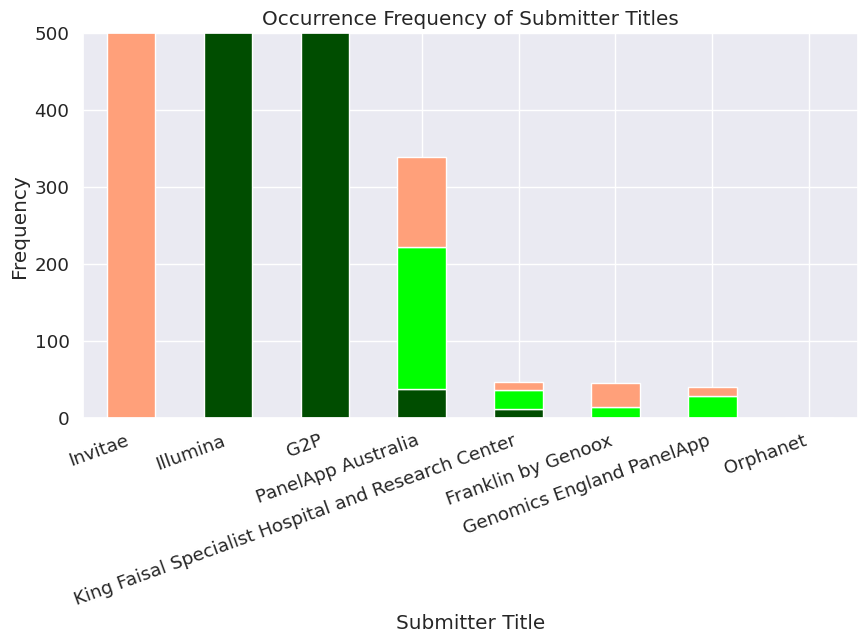

In [140]:
# Classification frequency by submitter title (definitive, moderate, limited classifications)

# Color dict for definitive, moderate, and limited classifications 
color_dict = {
    'Definitive': (0, 0.3, 0),
    'Moderate': (0, 1, 0),
    'Limited': 'lightsalmon'
}

# Group by 'submitter_title' and 'submitted_as_classification_name', count the size, unstack and fill NaN with 0
grouped_df = gencc_s.groupby(['submitter_title', 'submitted_as_classification_name']).size().unstack(fill_value=0)

# Filter the DataFrame to only include the columns in color_dict
grouped_df = grouped_df[list(color_dict.keys())]

# Add a total column
grouped_df['Total'] = grouped_df.sum(axis=1)

# Sort by the total column in descending order
grouped_df = grouped_df.sort_values('Total', ascending=False)

# Remove the total column
grouped_df = grouped_df.drop(columns='Total')

# Plot a stacked bar plot with the colors from color_dict
grouped_df.plot(kind='bar', stacked=True, color=list(color_dict.values()), figsize=(10, 5))

plt.title('Occurrence Frequency of Submitter Titles')
plt.xlabel('Submitter Title')
plt.ylabel('Frequency')

plt.xticks(rotation=20, ha='right')
# REMOVE HERE FOR FULL PLOT
plt.ylim(0, 500)
# remove legend
plt.legend().remove()
plt.show()

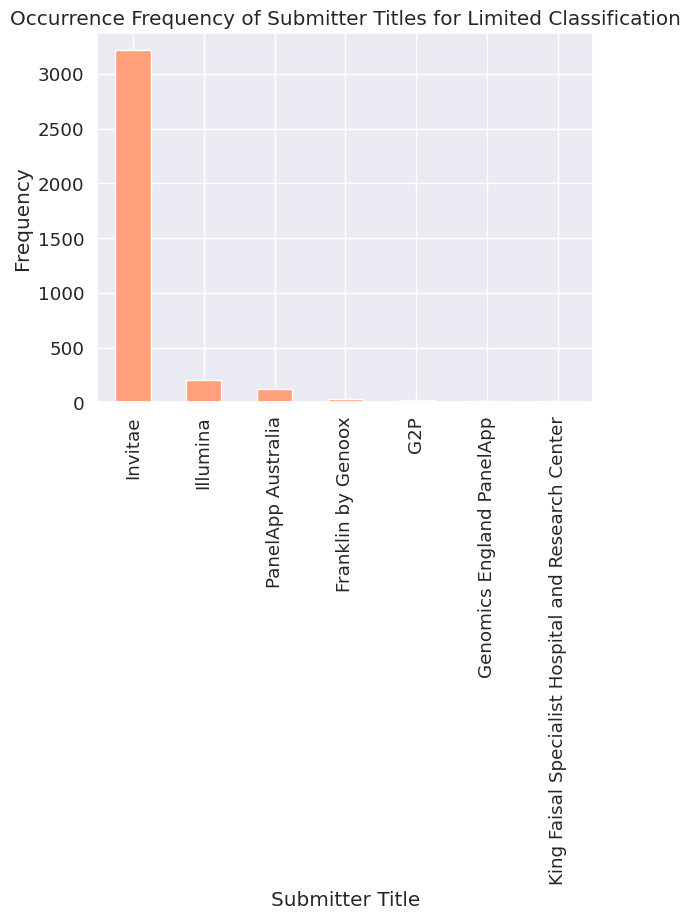

In [145]:
# Classification frequency by submitter title (one classification)

filtered_df = gencc_s[gencc_s['submitted_as_classification_name'].isin(['Limited'])]

filtered_df['submitter_title'].value_counts().plot(kind='bar', color="lightsalmon")

plt.title('Occurrence Frequency of Submitter Titles for Limited Classification')
plt.xlabel('Submitter Title')
plt.ylabel('Frequency')

plt.show()

# Create additional publication year column (by calling Entrez API)

In [6]:
# Get publication year given PMID

def get_pub_year(pmid):
    if not pmid:
        return "PMID is empty or null"
    Entrez.email = "ashleyconard@microsoft.com"  # Always tell NCBI who you are
    handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml", rettype="abstract")
    records = Entrez.read(handle)
    if records and 'PubmedArticle' in records and records['PubmedArticle']:
        pubmed_article = records['PubmedArticle'][0]
        if 'PubmedData' in pubmed_article and 'History' in pubmed_article['PubmedData'] and pubmed_article['PubmedData']['History']:
            return pubmed_article['PubmedData']['History'][-1]['Year']
        else:
            return "No history found for this PMID"
    else:
        return "No records found for this PMID"
    
pmid = "24939586" 
print(get_pub_year(pmid))

# Example records['PubmedArticle'][0]['PubmedData']['History']

#history_pubmed = [DictElement({'Year': '2016', 'Month': '6', 'Day': '17'}, attributes={'PubStatus': 'received'}), DictElement({'Year': '2017', 'Month': '1', 'Day': '16'}, attributes={'PubStatus': 'accepted'}), DictElement({'Year': '2017', 'Month': '1', 'Day': '21', 'Hour': '6', 'Minute': '0'}, attributes={'PubStatus': 'pubmed'}), DictElement({'Year': '2017', 'Month': '7', 'Day': '1', 'Hour': '6', 'Minute': '0'}, attributes={'PubStatus': 'medline'}), DictElement({'Year': '2017', 'Month': '1', 'Day': '21', 'Hour': '6', 'Minute': '0'}, attributes={'PubStatus': 'entrez'})]


2015


In [24]:
# Get publication year for each PMID in 'submitted_as_pmids' column, in chucks due to Entrez API limit

chunk_size = 50
chuck_enumeration = 3 # the next chunck_{i}.csv will start with this number
start_row = 5500  # 0-indexed, so 150 corresponds to the 151st row
chunks = [gencc_s[i:i+chunk_size] for i in range(start_row, gencc_s.shape[0], chunk_size)]

for i, chunk in enumerate(chunks, start=start_row//chunk_size):
    print("Chunk", i+chuck_enumeration)
    print(chunk['uuid'])
    chunk['pub_year'] = chunk['submitted_as_pmids'].apply(get_pub_year)
    
    # Save the chunk to a CSV file
    chunk.to_csv(f'chunk_{i+chuck_enumeration}.csv', index=False)
    
    # Sleep for a while to avoid hitting the server too frequently
    time.sleep(10)

# Concatenate all chunks
gencc_s = pd.concat([pd.read_csv(f'chunk_{i+chuck_enumeration}.csv') for i in range(start_row//chunk_size, len(chunks) + start_row//chunk_size)])

# Save the final DataFrame
gencc_s.to_csv('final.csv', index=False)

Chunk 113
5500    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5501    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5502    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5503    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5504    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5505    GENCC_000112-HGNC_12592-OMIM_263700-HP_0000007...
5506    GENCC_000112-HGNC_5273-OMIM_224410-HP_0000007-...
5507    GENCC_000112-HGNC_5273-OMIM_224410-HP_0000007-...
5508    GENCC_000112-HGNC_5273-OMIM_224410-HP_0000007-...
5509    GENCC_000112-HGNC_14295-OMIM_613436-HP_0000006...
5510    GENCC_000112-HGNC_7720-OMIM_256030-HP_0000007-...
5511    GENCC_000112-HGNC_7720-OMIM_256030-HP_0000007-...
5512    GENCC_000112-HGNC_7720-OMIM_256030-HP_0000007-...
5513    GENCC_000112-HGNC_20499-OMIM_236792-HP_0000007...
5514    GENCC_000112-HGNC_20499-OMIM_236792-HP_0000007...
5515    GENCC_000112-HGNC_3687-OMIM_612961-HP_0000006-...
5516    GENCC_000112-HGNC_17168-OMIM_212720-HP_0000007...
5517

/tmp/ipykernel_277522/859859957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['pub_year'] = chunk['submitted_as_pmids'].apply(get_pub_year)


Chunk 114
5550    GENCC_000112-HGNC_5172-OMIM_209500-HP_0000007-...
5551    GENCC_000112-HGNC_5172-OMIM_209500-HP_0000007-...
5552    GENCC_000112-HGNC_5172-OMIM_209500-HP_0000007-...
5553    GENCC_000112-HGNC_5172-OMIM_209500-HP_0000007-...
5554    GENCC_000112-HGNC_5172-OMIM_209500-HP_0000007-...
5555    GENCC_000112-HGNC_30611-OMIM_615597-HP_0000007...
5556    GENCC_000112-HGNC_30664-OMIM_616271-HP_0000007...
5557    GENCC_000112-HGNC_30664-OMIM_616271-HP_0000007...
5558    GENCC_000112-HGNC_6697-OMIM_601813-HP_0000006-...
5559    GENCC_000112-HGNC_6697-OMIM_601813-HP_0000006-...
5560    GENCC_000112-HGNC_6697-OMIM_601813-HP_0000006-...
5561    GENCC_000112-HGNC_6697-OMIM_601813-HP_0000006-...
5562    GENCC_000112-HGNC_2928-OMIM_300376-HP_0001419-...
5563    GENCC_000112-HGNC_2928-OMIM_300376-HP_0001419-...
5564    GENCC_000112-HGNC_2928-OMIM_300376-HP_0001419-...
5565    GENCC_000112-HGNC_2928-OMIM_300376-HP_0001419-...
5566    GENCC_000112-HGNC_2928-OMIM_300376-HP_0001419-...
5567

/tmp/ipykernel_277522/859859957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['pub_year'] = chunk['submitted_as_pmids'].apply(get_pub_year)


Chunk 115
5600    GENCC_000112-HGNC_7905-OMIM_256100-HP_0000007-...
5601    GENCC_000112-HGNC_7905-OMIM_256100-HP_0000007-...
5602    GENCC_000112-HGNC_9122-OMIM_276300-HP_0000007-...
5603    GENCC_000112-HGNC_9122-OMIM_276300-HP_0000007-...
5604    GENCC_000112-HGNC_17075-OMIM_612863-HP_0000006...
5605    GENCC_000112-HGNC_17075-OMIM_612863-HP_0000006...
5606    GENCC_000112-HGNC_6716-OMIM_601216-HP_0000007-...
5607    GENCC_000112-HGNC_8923-OMIM_601815-HP_0000007-...
5608    GENCC_000112-HGNC_8923-OMIM_601815-HP_0000007-...
5609    GENCC_000112-HGNC_8923-OMIM_601815-HP_0000007-...
5610    GENCC_000112-HGNC_8923-OMIM_601815-HP_0000007-...
5611    GENCC_000112-HGNC_29262-OMIM_611263-HP_0000007...
5612    GENCC_000112-HGNC_3801-OMIM_153400-HP_0000006-...
5613    GENCC_000112-HGNC_3801-OMIM_153400-HP_0000006-...
5614    GENCC_000112-HGNC_3801-OMIM_153400-HP_0000006-...
5615    GENCC_000112-HGNC_3801-OMIM_153400-HP_0000006-...
5616    GENCC_000112-HGNC_3801-OMIM_153400-HP_0000006-...
5617

CorruptedXMLError: Failed to parse the XML data (not well-formed (invalid token): line 7, column 69). Please make sure that the input data are not corrupted.

In [26]:
# Merge chunks into one df
import glob

# Get a list of all CSV files
files = sorted(glob.glob('chunks/chunk_*.csv'), key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read and concatenate all files in numerical order
gencc_s_date = pd.concat((pd.read_csv(file) for file in files))

# Remove duplicates
gencc_s_date = gencc_s_date.drop_duplicates()

# Print df
gencc_s_date

,uuid,gene_curie,gene_symbol,disease_curie,disease_title,disease_original_curie,disease_original_title,classification_curie,classification_title,moi_curie,...,submitted_as_classification_id,submitted_as_classification_name,submitted_as_date,submitted_as_public_report_url,submitted_as_notes,submitted_as_pmids,submitted_as_assertion_criteria_url,submitted_as_submission_id,submitted_run_date,pub_year
0,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,24939586,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08,2015
1,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,25862627,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08,2015
2,GENCC_000104-HGNC_23336-MONDO_0018997-HP_00000...,HGNC:23336,A2ML1,MONDO:0018997,Noonan syndrome,MONDO:0018997,Noonan syndrome,GENCC:100004,Limited,HP:0000006,...,GENCC:100004,Limited,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,27942422,NaN,000104.pa48.v1.73.hgnc23336.m1.p1,2020-10-08,2016
3,GENCC_000104-HGNC_1097-OMIM_613707-HP_0000006-...,HGNC:1097,BRAF,MONDO:0013380,LEOPARD syndrome 3,OMIM:613707,LEOPARD syndrome 3,GENCC:100002,Strong,HP:0000006,...,GENCC:100002,Strong,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,19206169,NaN,000104.pa48.v1.73.hgnc1097.m1.p1,2020-10-08,2009
4,GENCC_000104-HGNC_1097-OMIM_613707-HP_0000006-...,HGNC:1097,BRAF,MONDO:0013380,LEOPARD syndrome 3,OMIM:613707,LEOPARD syndrome 3,GENCC:100002,Strong,HP:0000006,...,GENCC:100002,Strong,2020-10-07 20:04:14,https://panelapp.genomicsengland.co.uk/panels/48/,NaN,21396583,NaN,000104.pa48.v1.73.hgnc1097.m1.p1,2020-10-08,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,GENCC_000112-HGNC_20800-OMIM_269250-HP_0000007...,HGNC:20800,SLC35D1,MONDO:0010013,schneckenbecken dysplasia,OMIM:269250,Schneckenbecken dysplasia,GENCC:100001,Definitive,HP:0000007,...,GENCC:100001,NaN,2015-07-22 00:00:00,NaN,NaN,11200994,https://www.ebi.ac.uk/gene2phenotype/terminology,1000114700,2023-09-11,2001
46,GENCC_000112-HGNC_20800-OMIM_269250-HP_0000007...,HGNC:20800,SLC35D1,MONDO:0010013,schneckenbecken dysplasia,OMIM:269250,Schneckenbecken dysplasia,GENCC:100001,Definitive,HP:0000007,...,GENCC:100001,NaN,2015-07-22 00:00:00,NaN,NaN,35934917,https://www.ebi.ac.uk/gene2phenotype/terminology,1000114700,2023-09-11,2022
47,GENCC_000112-HGNC_20800-OMIM_269250-HP_0000007...,HGNC:20800,SLC35D1,MONDO:0010013,schneckenbecken dysplasia,OMIM:269250,Schneckenbecken dysplasia,GENCC:100001,Definitive,HP:0000007,...,GENCC:100001,NaN,2015-07-22 00:00:00,NaN,NaN,19508970,https://www.ebi.ac.uk/gene2phenotype/terminology,1000114700,2023-09-11,2009
48,GENCC_000112-HGNC_7905-OMIM_256100-HP_0000007-...,HGNC:7905,NPHP1,MONDO:0009728,nephronophthisis 1,OMIM:256100,"Nephronophthisis 1, juvenile",GENCC:100001,Definitive,HP:0000007,...,GENCC:100001,NaN,2015-07-22 00:00:00,NaN,NaN,9382140,https://www.ebi.ac.uk/gene2phenotype/terminology,1000114701,2023-09-11,1997


In [36]:
# Save the final DataFrame with pub year

gencc_s_date.to_csv('gencc_pub_date.csv', index=False)

# Import GenCC data with publication dates extracted

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

gencc_s_date = pd.read_csv("/home/azureuser/ev-agg-exp/data/gencc_pub_date.csv", header=0)

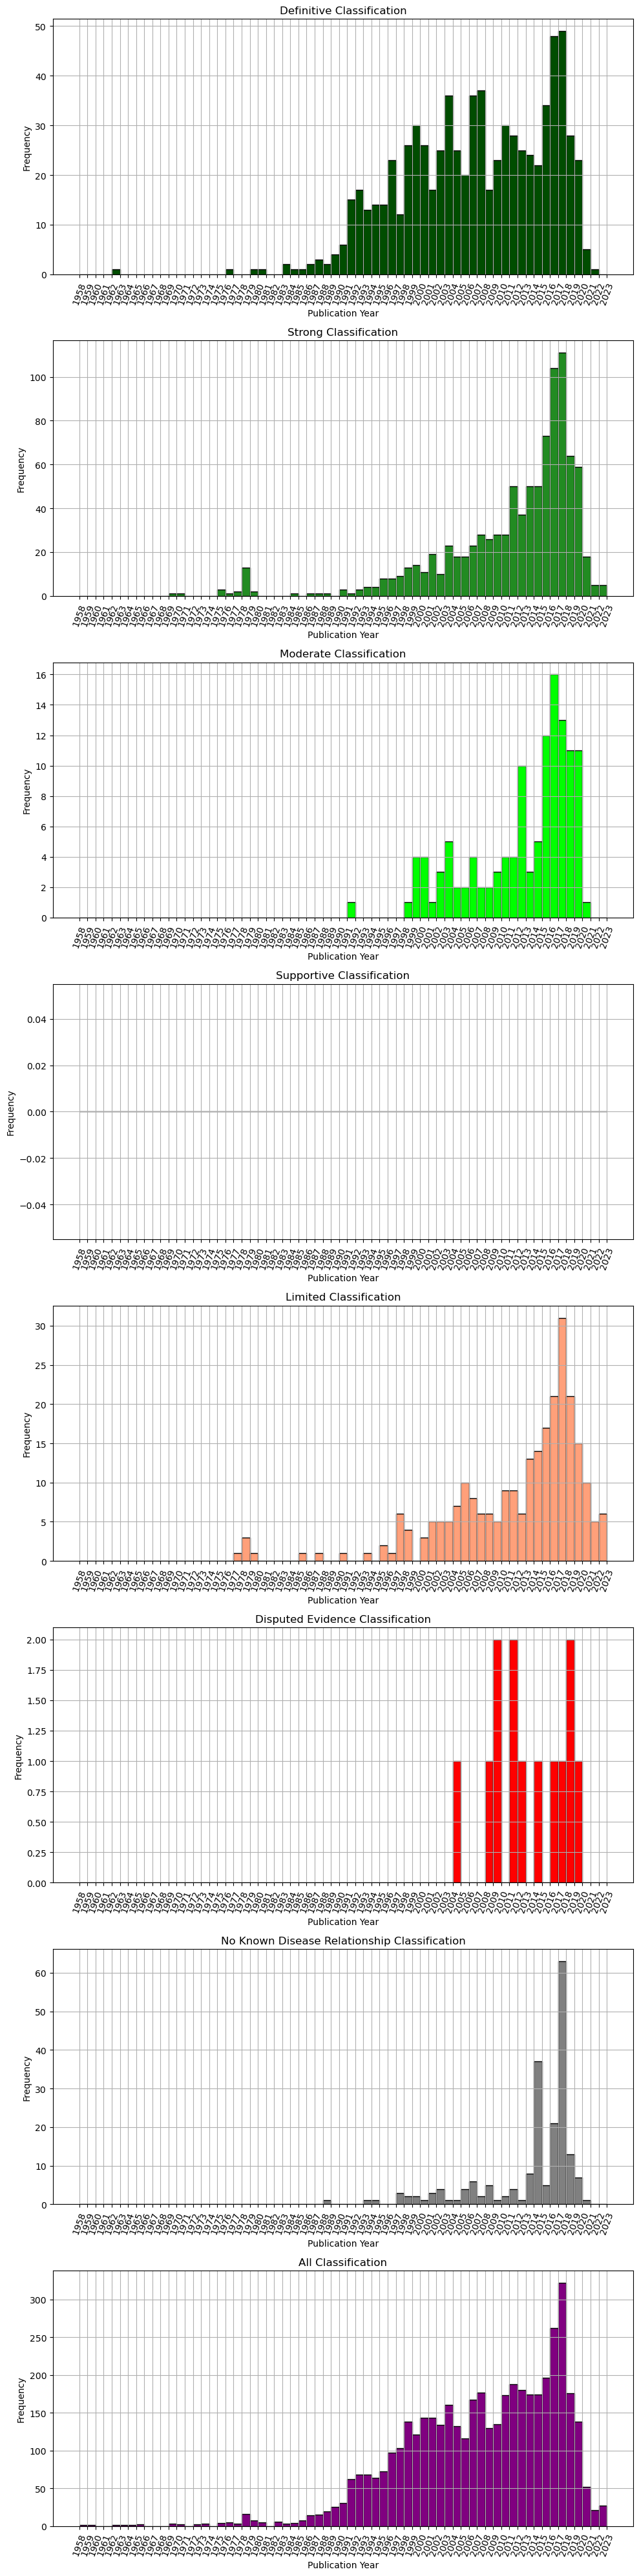

In [7]:
# Plot a histogram of the pub_year for each classification

# Ensure 'pub_year' is numeric
gencc_s_date['pub_year'] = pd.to_numeric(gencc_s_date['pub_year'], errors='coerce')

# Get the minimum and maximum years from the 'pub_year' column
min_year = int(gencc_s_date['pub_year'].min())
max_year = int(gencc_s_date['pub_year'].max()) + 1  # Add 1 to include the maximum year in the range

# Define classifications and their corresponding colors
classifications = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey',
    'All': 'purple'
}

# Create a figure with a subplot for each classification
fig, axs = plt.subplots(len(classifications), 1, figsize=(10, 5*len(classifications)))

# Plot a histogram of the pub_year for each classification
for i, (classification, color) in enumerate(classifications.items()):
    if classification == 'All':
        data = gencc_s_date
    else:
        data = gencc_s_date[gencc_s_date['submitted_as_classification_name'] == classification]
    
    data['pub_year'].hist(ax=axs[i], color=color, bins=range(min_year, max_year), edgecolor='black')
    axs[i].set_title(f'{classification} Classification')
    axs[i].set_xticks(range(min_year, max_year))  # Set x-axis ticks
    axs[i].set_xticklabels(range(min_year, max_year), rotation=70)  # Rotate x-axis labels
    axs[i].set_xlabel('Publication Year')  # Set x-axis label
    axs[i].set_ylabel('Frequency')  # Set y-axis label

plt.tight_layout()
plt.show()

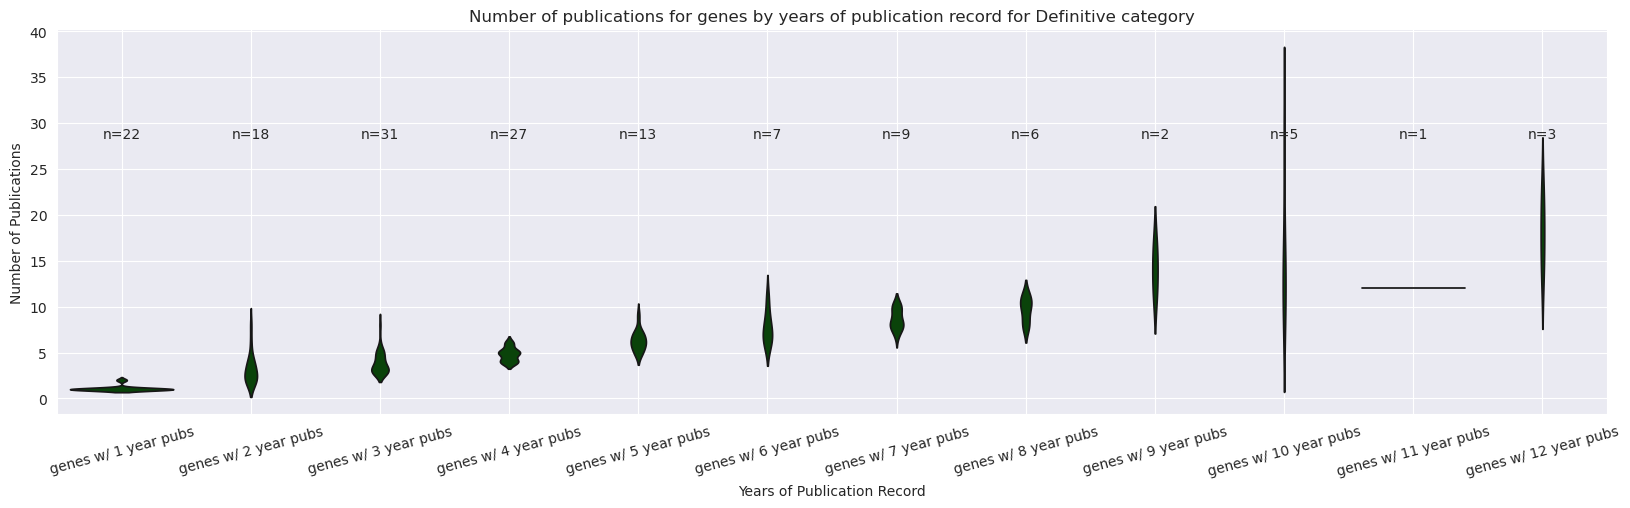

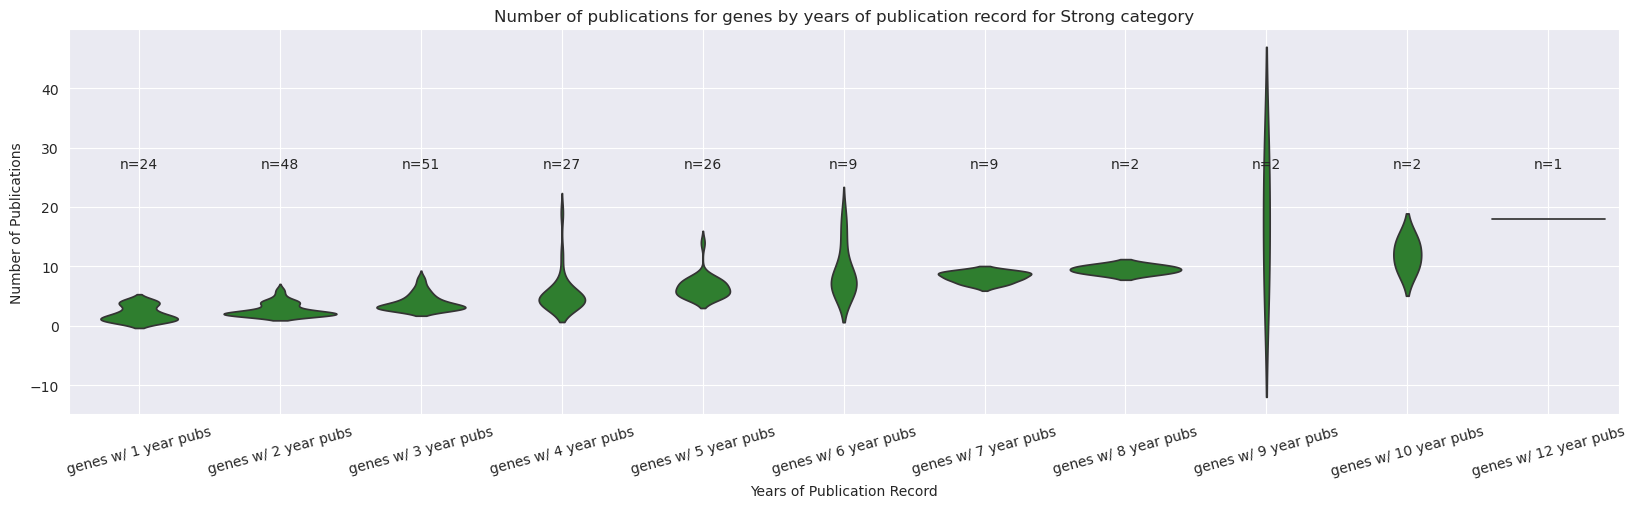

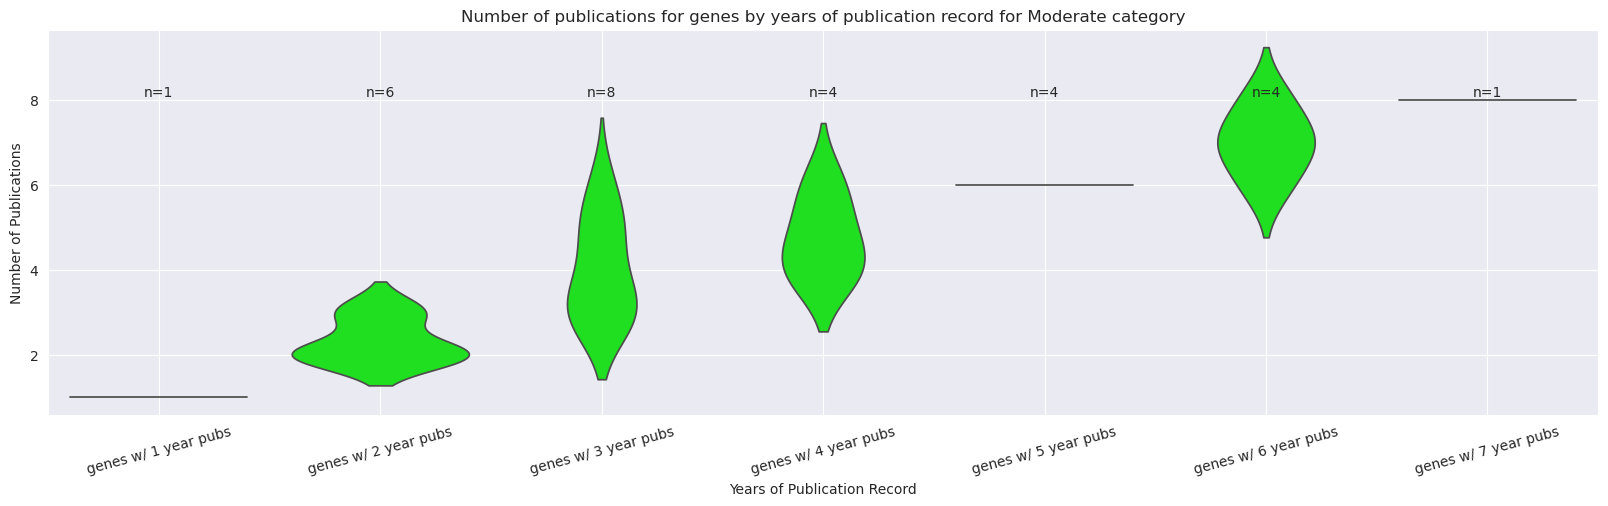

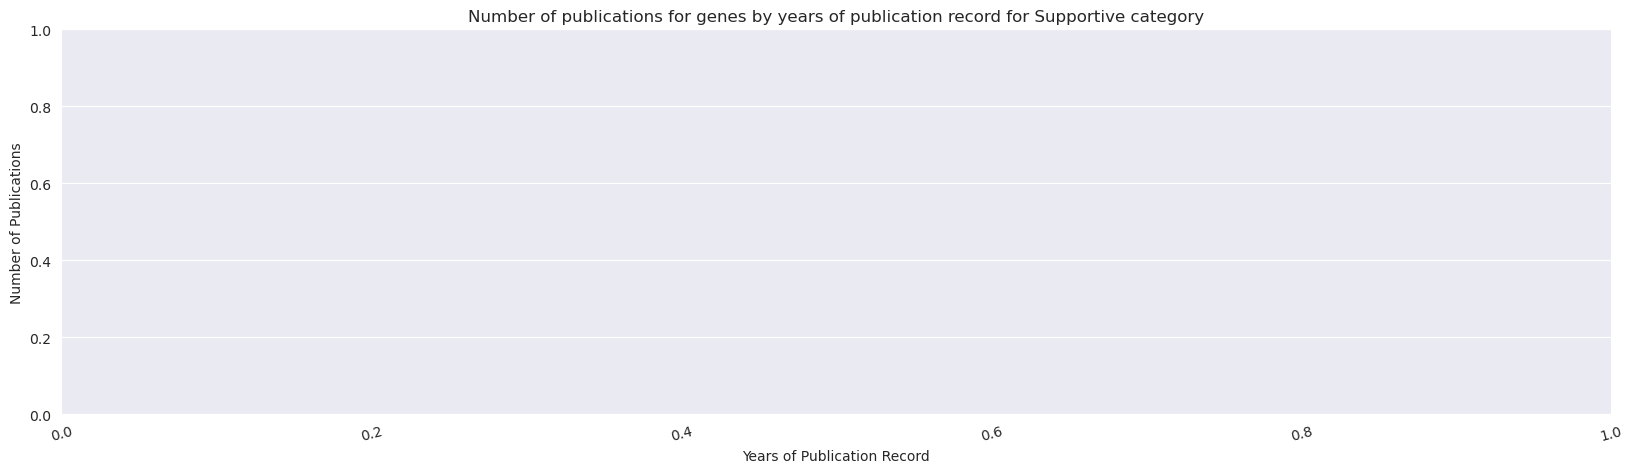

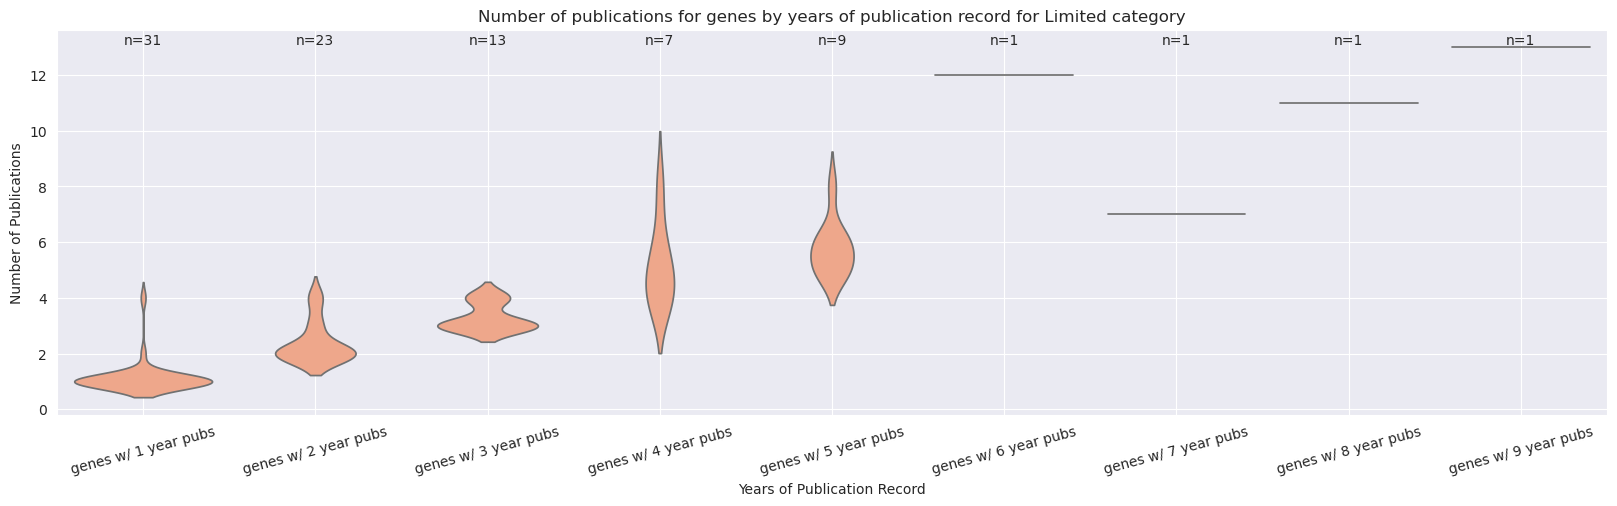

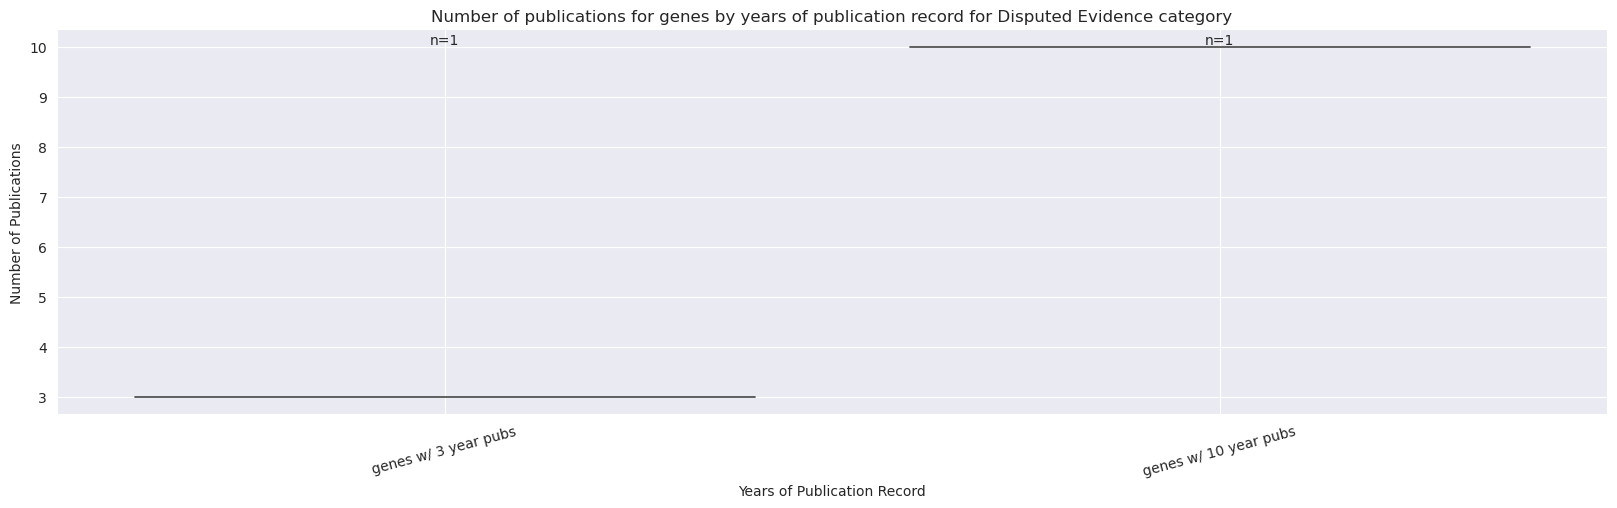

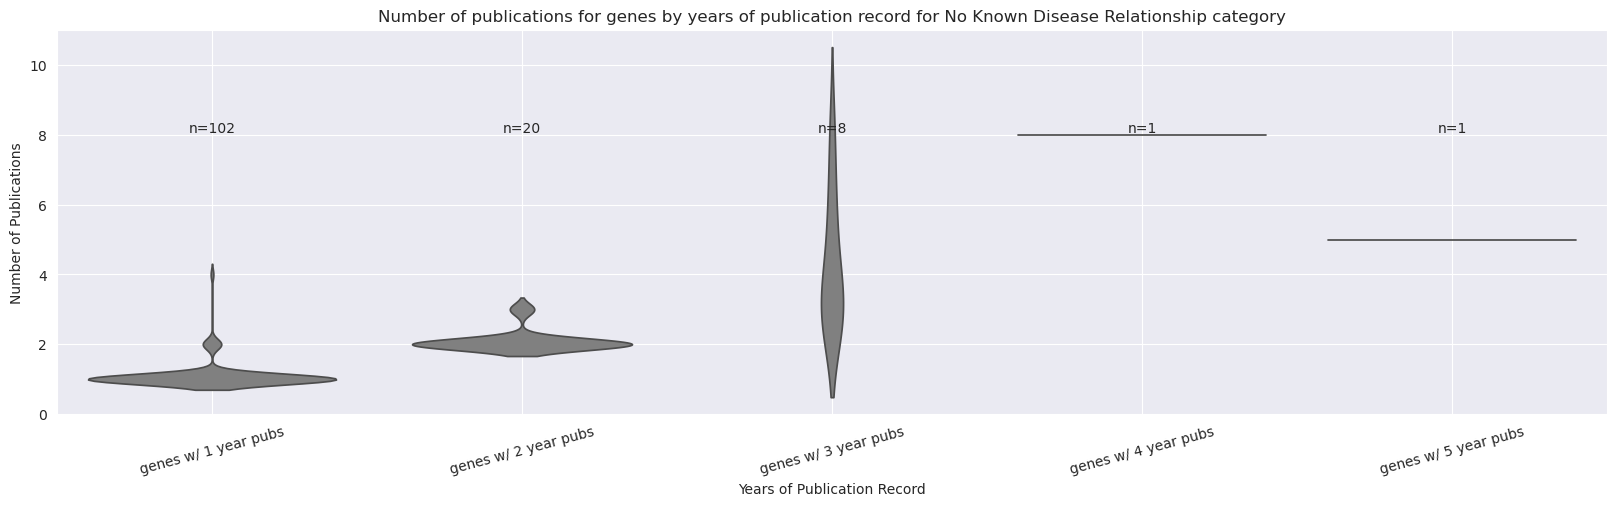

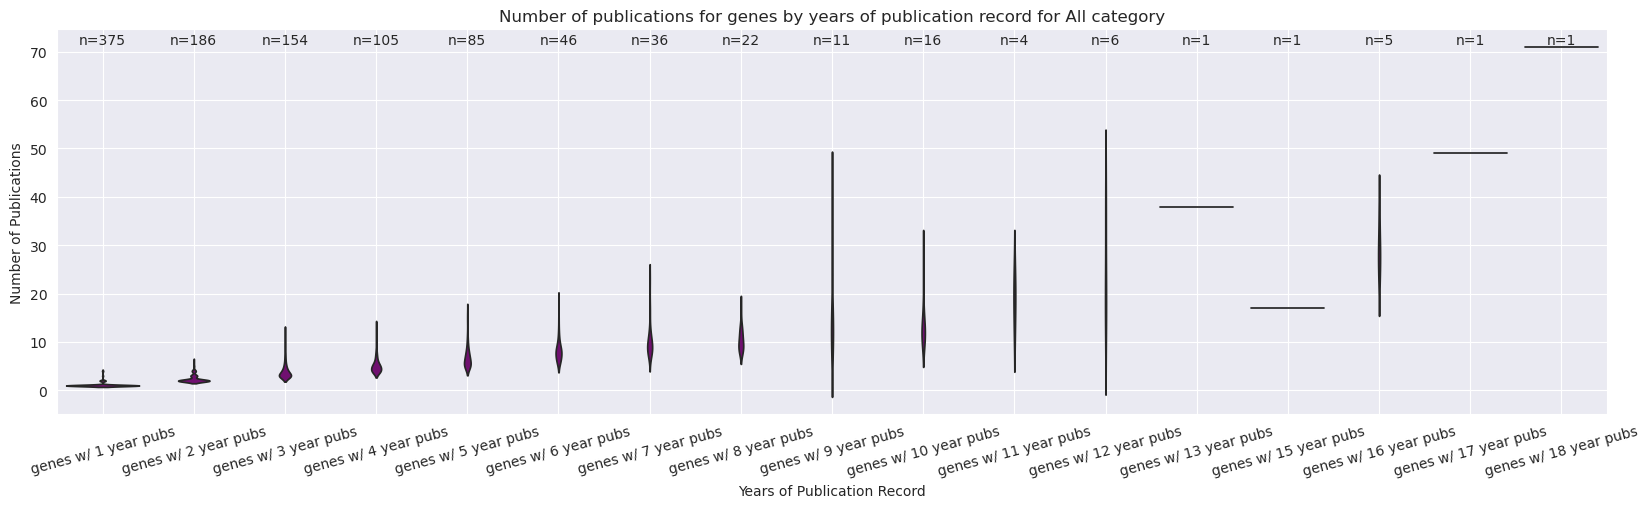

In [11]:
# Calculate the number of years each gene has had publications according to GenCC. Note that this is not the same as the number of years the gene has been published, as GenCC only includes publications that are relevant to the gene-disease relationship by their estimation (i.e. not complete/exhaustive list)

col_classif = {
    'Definitive': (0, 0.3, 0),
    'Strong': 'forestgreen',
    'Moderate': (0, 1, 0),
    'Supportive': 'lightblue',
    'Limited': 'lightsalmon',
    'Disputed Evidence': 'red',
    'No Known Disease Relationship': 'grey',
    'All': 'purple'
}
sns.set_style("darkgrid")

for classification, color in col_classif.items():
    if classification == 'All':
        df = gencc_s_date
    else:
        df = gencc_s_date[gencc_s_date['submitted_as_classification_name'] == classification]
    
    # Calculate the number of years each gene has had publications
    grouped_years = df.groupby('gene_symbol')['pub_year'].nunique()

    # Calculate the total number of publications for each gene
    grouped_publications = df.groupby('gene_symbol').size()

    # Combine the two dataframes into one
    grouped_df = pd.DataFrame({'years_of_publications': grouped_years, 'number_of_publications': grouped_publications})

    # Create a new column 'years_of_publications_label' to use as the x-axis in the plot
    grouped_df['years_of_publications_label'] = 'genes w/ ' + grouped_df['years_of_publications'].astype(str) + ' year pubs'

    # Create violin plot
    plt.figure(figsize=(20, 5))
    order = sorted(grouped_df['years_of_publications_label'].unique(), key=lambda x: int(x.split(' ')[2]))
    sns.violinplot(x='years_of_publications_label', y='number_of_publications', data=grouped_df, inner=None, color=color, order=order)

    plt.xticks(rotation=15)
    plt.xlabel('Years of Publication Record')
    plt.ylabel('Number of Publications')
    plt.title(f"Number of publications for genes by years of publication record for {classification} category")
    plt.grid(axis='x')

    # Add count of data points for each violin
    counts = grouped_df['years_of_publications_label'].value_counts().loc[order]
    for i, count in enumerate(counts):
        plt.text(i, grouped_df['number_of_publications'].max(), f'n={count}', ha='center', va='bottom')  # adjust y-coordinate as needed

    plt.show()